# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import os
import zipfile

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

# Get and Unzip Dataset

In [ ]:
# Using GDrive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Base Directory
base_dir = '/content/gdrive/My Drive/ML/'
# base_dir = 'E:/Kuliah/Bangkit/Capstone/ML/'

In [ ]:
# Unzip Dataset 2
if os.path.exists(os.path.join(base_dir, 'New Plant Diseases Dataset(Augmented)')) == False:
  local_zip = os.path.join(base_dir, 'vipooooolnew-plant-diseases-dataset.zip')
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall(base_dir)
  zip_ref.close()

# Preprocessing

## Rename Folders

In [ ]:
base_dir = '/content'
dataset_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
subfolders = ['train', 'valid']

In [ ]:
# List files
print(os.listdir(os.path.join(dataset_path, 'train')))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
subfolders = ['train', 'valid']
folders = []
plants = []

In [ ]:
# Saran: sebaiknya bagian "if ... in status" dipindahkan dalam bentuk fungsi (done)

In [ ]:
# Function to rename folder or move files to another folder
def move_or_rename(folder, old_path, new_path):
    # Pindahkan saja jika sudah ada
      if folder in status:                              # if 'healthy' in status
        files = os.listdir(old_path)                    # file di 'Tomato___healthy'
        
        # Iterasi semua file
        for f in files:
          src_path = os.path.join(old_path, f)          # 'Tomato___healthy'
          dst_path = os.path.join(new_path, f)          # 'healthy'
          os.rename(src_path, dst_path)

      else:                                             # if 'healthy' not in status
        os.rename(old_path, new_path)
        status.append(folder)                           # insert 'healthy' to status

In [ ]:
status = []

In [ ]:
# Menghapus kata (jenis tanaman) sebelum "___" dan menghapus jenis tanaman jika
# masih ada

# For all (train and valid) folders
for sub in subfolders:
  sub_path = os.path.join(dataset_path, sub)
  
  for folder in os.listdir(sub_path):
    # Hapus kata sebelum "___" jika ada
    if "___" in folder:
      id = folder.rfind("___")
      plant_name = folder[:id]

      # Me-rename folder
      old_path = os.path.join(sub_path, folder)
      new_path = os.path.join(sub_path, folder[id+3:])

      move_or_rename(folder[id+3:], old_path, new_path)

      # Hapus jenis tanaman jika masih ada 
      folder = folder[id+3:]
      if plant_name in folder:
        plant_len = len(plant_name)

        # Me-rename folder
        old_path = new_path 
        new_path = os.path.join(sub_path, folder[plant_len+1:])

        move_or_rename(folder[plant_len+1:], old_path, new_path)

  status = []

In [ ]:
# Delete empty folders
for sub in subfolders:
  sub_path = os.path.join(dataset_path, sub)
  
  for folder in os.listdir(sub_path):
    if not os.listdir(os.path.join(sub_path, folder)):
        print(f'Deleting {os.path.join(sub_path, folder)}...')
        os.removedirs(os.path.join(sub_path, folder))

In [ ]:
# Semua status tanaman dan jumlahnya
directory_files = os.listdir(os.path.join(dataset_path, 'train'))
print(f'Status penyakit tanaman: {directory_files}')
print(f'Jumlah: {len(directory_files)}')

## ImageDataGenerator Setup

In [ ]:
training_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'valid')
print(training_dir)
print(validation_dir)

In [ ]:
# Function to use ImageDataGenerator from image directory
def train_val_generators(training_dir, validation_dir):

  train_datagen = ImageDataGenerator(rescale=1/255)

  train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=(150, 150),
                                                      shuffle=True)

  validation_datagen = ImageDataGenerator(rescale=1/255)

  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=20,
                                                                class_mode='categorical',
                                                                target_size=(150, 150),
                                                                shuffle=True)
  
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)
# Output: 
# Found 70295 images belonging to 21 classes.
# Found 17572 images belonging to 21 classes.

# Training Model

## Setup

In [ ]:
# Function to plot accuracy from history
def plot_accuracy(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs

    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.show()
    print("")

    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

In [ ]:
# Test the model
def model_prediction(model):
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    print(classes.argmax(axis=-1))

## Self-Made Model 1

In [ ]:
# Create the model
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(21, activation='softmax')
])

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']) 

In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator)

# Output last epoch
# Epoch 10/10
# 3515/3515 [==============================] - 2091s 595ms/step - loss: 0.0332 - accuracy: 0.9907 - val_loss: 0.5553 - val_accuracy: 0.9094

In [ ]:
plot_accuracy(history)

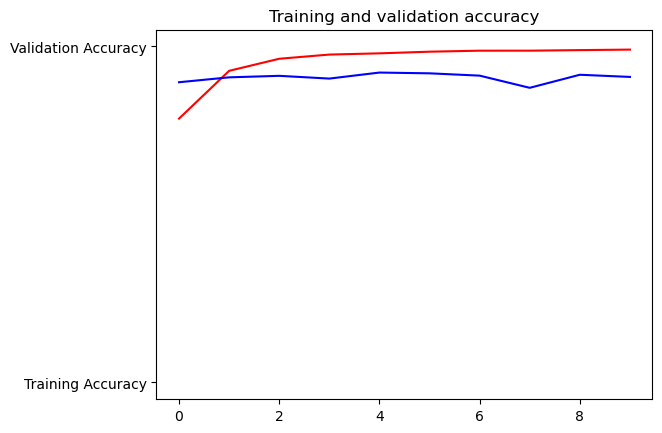

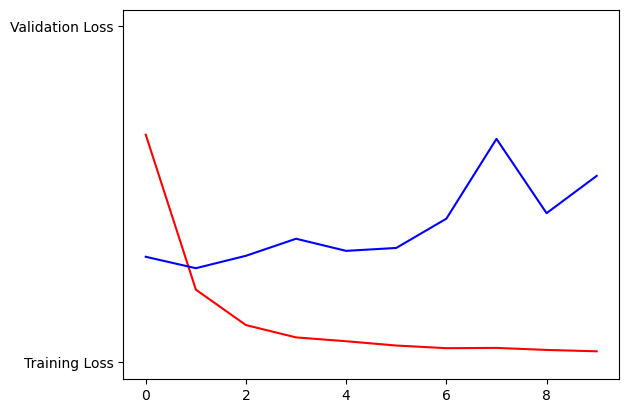

In [ ]:
# Test model


In [ ]:
# Load model
model.save('E:/Kuliah/Bangkit/Capstone/ML/model_self.h5')
model.save('E:/Kuliah/Bangkit/Capstone/ML/model_self.keras')

## Self-Made Model 2

In [ ]:
# Create the model
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(21, activation='softmax')
])

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']) 

In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator)

# Last epoch
# Epoch 10/10
# 3515/3515 [==============================] - 1775s 505ms/step - loss: 0.0585 - accuracy: 0.9823 - val_loss: 0.4263 - val_accuracy: 0.9153

In [ ]:
plot_accuracy(history)

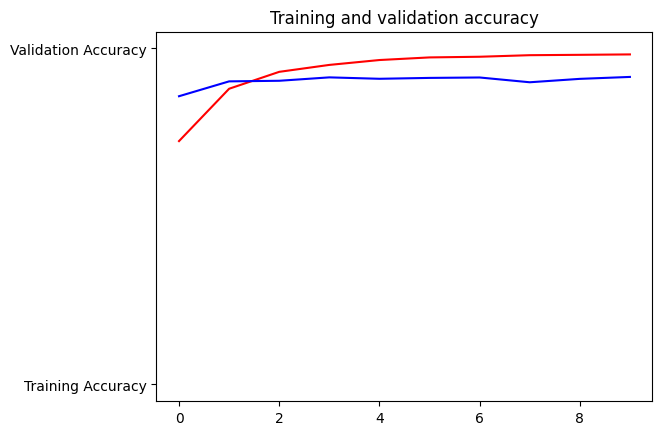

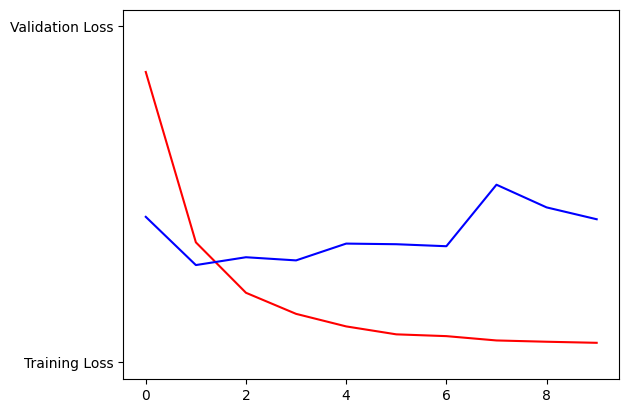

In [ ]:
# Save model
model.save('model_self_v2.keras')
model.save('model_self_v2.h5')

In [ ]:
# Load model
# model = tf.keras.models.load_model('/content/model_self.h5')

In [ ]:
model_prediction(model)

## Transfer Learning using MobileNetV2

In [ ]:
model_mobilenetv2 = tf.keras.applications.MobileNetV2(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(150, 150, 3))

for layer in model_mobilenetv2.layers:
    layer.trainable = False

In [ ]:
# Create the model
model = tf.keras.Sequential([
    model_mobilenetv2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(21, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator)

# Output last epoch
# Epoch 10/10
# 3515/3515 [==============================] - 2797s 796ms/step - loss: 0.0541 - accuracy: 0.9821 - val_loss: 0.2471 - val_accuracy: 0.9452

In [ ]:
plot_accuracy(history)

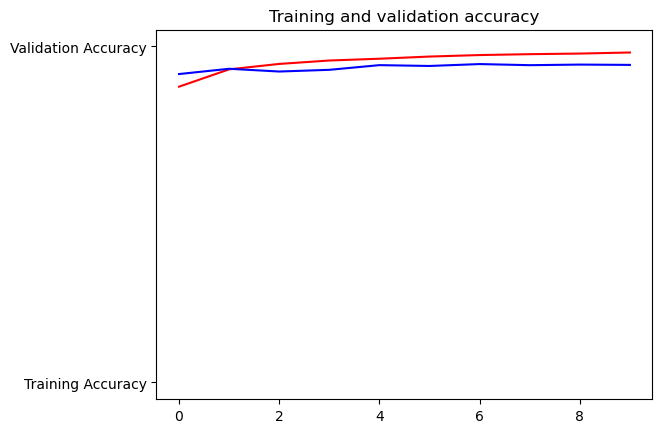

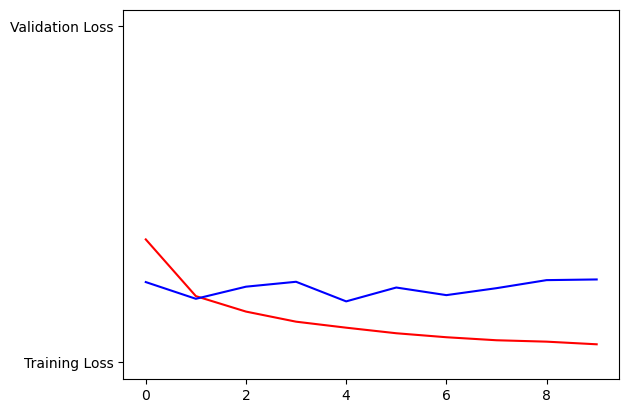

In [ ]:
# Test Model


In [ ]:
# Load model
model.save('E:/Kuliah/Bangkit/Capstone/ML/model_mobilenetv2.keras')
model.save('E:/Kuliah/Bangkit/Capstone/ML/model_mobilenetv2.h5')

## Transfer Learning using InceptionV3

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
model_inceptionv3 = InceptionV3(weights='imagenet',
                                include_top=False,
                                input_shape=(150, 150, 3))

for layer in model_inceptionv3.layers:
    layer.trainable = False